# Assistent Agentic AI Developer Certification: LangGraph-Orchestrated Research Assistant for Ready Tensor


## Introduction  
This notebook provides an interactive workflow to analyze, compare, and summarize AI/ML publications using modern LLM- and agent-based tools. By leveraging LangGraph, LangChain, and external APIs, users can select, process, and compare research articles or technical reports from the Ready Tensor sample dataset.     

To sum up, the **LangGraph-Orchestrated Research Assistant for Ready Tensor** is a comprehensive workflow for analyzing, comparing, and summarizing AI/ML publications using modern LLM-powered agents.   

This notebook guides you through data inspection, pipeline orchestration, and visualization for robust, user-driven publication analysis. It demonstrates how to:  
- Load and manage API credentials securely
- Inspect and process a collection of sample AI/ML publications
- Orchestrate analysis and comparison using LangGraph, LangChain, and agentic workflows
- Visualize the orchestration pipeline
- Provide interactive, user-driven exploration and comparison of research output



###  Environment Setup    
#### Load Environment Variables

In [ ]:
# Load API keys from .env file for secure credential management
from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Print masked keys for confirmation (never reveal full secrets)
if openai_api_key:
    print("OPENAI_API_KEY loaded successfully.")
    print(f"OPENAI_API_KEY: {openai_api_key[:5]}{'*' * (len(openai_api_key) - 10)}{openai_api_key[-5:]}")
else:
    print("OPENAI_API_KEY not found. Please check your .env file.")

if tavily_api_key:
    print(f"TAVILY_API_KEY: {tavily_api_key[:5]}*****")
else:
    print("TAVILY_API_KEY not found. Please check your .env file.")

#### Import Core Libraries

In [ ]:
# Core imports for LangGraph orchestration and state
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import TypedDict, Annotated, List, Optional
import operator

# LangChain and agent tools
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_core.tools import Tool
from langchain_community.tools.tavily_search.tool import TavilySearchResults

### API Clients Initialization

In [ ]:
# Initialize LLM and external API clients
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
from tavily import TavilyClient
tavily = TavilyClient(api_key=tavily_api_key)

### Data Preparation  
#### Inspect Ready Tensor Sample Dataset  

In [ ]:
import json

# Load dataset and print publication titles
with open("project_1_publications.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print("Sample Publications:")
for item in data:
    print("-", item.get("title"))

#### Save Publications as .txt Files in the folder `sample_publications` 

In [ ]:
import os

output_dir = "sample_publications"
os.makedirs(output_dir, exist_ok=True)

for idx, item in enumerate(data):
    title = item.get("title", f"publication_{idx}")
    safe_title = "".join(c if c.isalnum() or c in " _-" else "_" for c in title)
    filename = os.path.join(output_dir, f"{safe_title}.txt")
    with open(filename, "w", encoding="utf-8") as txt_file:
        txt_file.write(f"{item.get('title', '')}\n\n")
        for key, value in item.items():
            if key != "title":
                txt_file.write(f"{key.capitalize()}:\n{value}\n\n")
print(f"Saved {len(data)} publications to '{output_dir}'")

### LangGraph Orchestration Framework (LangGraph Orchestration Pipeline)  
#### Agent State Class (Agent State Definition) > PublicationExplorer Orchestration > User Interaction & Visualization > Publication Selection & Query > Run the Orchestration

In [ ]:
# Define the state for orchestration steps
class AgentState(TypedDict):
    pub1_path: str
    pub2_path: str
    user_query: str
    pub1_profile: Optional[str]
    pub2_profile: Optional[str]
    comparison: Optional[str]
    trends: Optional[str]
    summary: Optional[str]
    fact_check: Optional[str]
    extra_info: Optional[str]
    lnode: Optional[str]
    count: int

MAX_CHARS = 12000

# Dummy tool implementations (replace with real logic)
class KeywordTagExtractor:
    def run(self, text: str) -> str:
        return "Keywords: NLP, HuggingFace, Evaluation Metrics"

class RAGRetriever:
    def run(self, query: str) -> str:
        return f"Retrieved info for query: {query}"

# PublicationExplorer: orchestrates analysis, comparison, summarization, and fact-checking
class PublicationExplorer():
    def __init__(self):
        self.model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        # Prompts for each orchestration stage
        # Analyze_pub1/analyze_pub2: Analyze each publication for structured attributes (tools, tasks, datasets, results).
        self.PROFILE_PROMPT = (
            "You are an expert scientific reviewer. "
            "Extract the following attributes from the publication below:\n"
            "- Tool usage (list all tools and libraries)\n"
            "- Evaluation methods (describe metrics and benchmarks)\n"
            "- Task types (summarize the main tasks addressed)\n"
            "- Datasets (list datasets used)\n"
            "- Results (summarize key findings)\n"
            "Format your answer as a structured bullet list.\n\n"
            "Publication:\n{text}"
        )
        #Compare: Side-by-side comparison on user-selected query.
        self.COMPARE_PROMPT = (
            "You are an expert comparative analyst.\n"
            "Compare the two research publications based on the extracted attributes below **and** the user query: '{query}'.\n\n"
            "**Instructions:**\n"
            "- Use a side-by-side comparison format grouped by:\n"
            "  • Tool usage\n"
            "  • Evaluation methods\n"
            "  • Task types\n"
            "  • Datasets\n"
            "  • Results\n"
            "- Highlight similarities, key differences, and any contradictions.\n"
            "- Mention anything notable or missing in either publication.\n"
            "- Avoid assumptions not directly supported by extracted attributes.\n\n"
            "**Inputs:**\n"
            "Publication 1 Attributes:\n{pub1_profile}\n\n"
            "Publication 2 Attributes:\n{pub2_profile}\n"
        )
        # Aggregate_trends: Extract trends and patterns from both profiles.
        self.TREND_PROMPT = (
            "You are a scientific trend analyst.\n\n"
            "Based on the attributes extracted from the two publications, identify any trends, patterns, or evolutions that are relevant to the query: '{query}'.\n\n"
            "**Instructions:**\n"
            "- Group findings into:\n"
            "  • Emerging tools or libraries\n"
            "  • Shifts in task types or problem domains\n"
            "  • Dataset usage trends or benchmarking practices\n"
            "  • Performance expectations or result improvements\n"
            "- Use bullet points for clarity.\n"
            "- Avoid speculation—only extract what is present in the source data.\n\n"
            "**Publication 1 Attributes:**\n{pub1_profile}\n\n"
            "**Publication 2 Attributes:**\n{pub2_profile}"
        )
        # Summarize: Generate a concise summary of findings.
        self.SUMMARY_PROMPT = (
            "You are a scientific summarizer.\n"
            "Summarize the findings from the comparison and trend analysis below in a concise, structured manner for the user.\n\n"
            "**Instructions:**\n"
            "- Limit to **5 to 7 bullet points**.\n"
            "- Capture the most significant findings, differences, and insights.\n"
            "- Focus on clarity, scientific precision, and user relevance.\n"
            "- Avoid repetition and assumptions.\n\n"
            "**Inputs:**\n"
            "Comparison:\n{comparison}\n\n"
            "Trends:\n{trends}"
        )
        # Fact_check: Validate all generated content against the original publications.
        self.FACTCHECK_PROMPT = (
            "You are a fact-checking assistant.\n"
            "Your task is to verify the accuracy of the following content (comparison, trends, and summary) against the original publication texts.\n\n"
            "**Instructions:**\n"
            "- Identify **unsupported claims**, **inaccurate statements**, or **fabrications**.\n"
            "- Cross-reference every factual assertion with the publications.\n"
            "- Use the following categories:\n"
            "  • Supported\n"
            "  • Partially supported (explain)\n"
            "  • Unsupported (explain and cite the original content)\n"
            "- Return a **structured list** of errors if any are found.\n\n"
            "**Content to Verify:**\n"
            "Comparison:\n{comparison}\n\n"
            "Trends:\n{trends}\n\n"
            "Summary:\n{summary}\n\n"
            "**Original Publications:**\n"
            "Publication 1:\n{pub1_text}\n\n"
            "Publication 2:\n{pub2_text}"
        )
        #RTag Extractor_tool: Use agentic tools to extract keywords.
        keyword_tool = Tool(
            name="KeywordTagExtractor",
            func=KeywordTagExtractor().run,
            description="Extracts keywords and tags from a scientific document."
        )
        #React_agent_tool: Use agentic tools to enrich or validate insights.
        rag_tool = Tool(
            name="RAGRetriever",
            func=RAGRetriever().run,
            description="Retrieves factual context from a document store."
        )
        #Web_agent_tool: Use agentic tools to search info in the web.
        search_tool = Tool(
            name="WebSearch",
            func=TavilySearchResults().run,
            description="Searches the web for datasets, tools, or benchmarks."
        )
        self.react_agent = initialize_agent(
            tools=[keyword_tool, rag_tool, search_tool],
            llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
            agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True
        )

        # Build and compile the LangGraph pipeline
        builder = StateGraph(AgentState)
        builder.add_node("analyze_pub1", self.analyze_pub1)
        builder.add_node("analyze_pub2", self.analyze_pub2)
        builder.add_node("compare", self.compare)
        builder.add_node("aggregate_trends", self.aggregate_trends)
        builder.add_node("summarize", self.summarize)
        builder.add_node("fact_check_node", self.fact_check)
        builder.add_node("react_agent_tool", self.react_agent_tool)

        builder.set_entry_point("analyze_pub1")
        builder.add_edge("analyze_pub1", "analyze_pub2")
        builder.add_edge("analyze_pub2", "compare")
        builder.add_edge("compare", "aggregate_trends")
        builder.add_edge("aggregate_trends", "summarize")
        builder.add_edge("summarize", "fact_check_node")
        builder.add_edge("fact_check_node", "react_agent_tool")
        builder.add_edge("react_agent_tool", END)
        self.graph = builder.compile()

        

    def read_txt(self, path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read()[:MAX_CHARS]

    def analyze_pub1(self, state: AgentState):
        text = self.read_txt(state["pub1_path"])
        prompt = self.PROFILE_PROMPT.replace("{text}", text)
        response = self.model.invoke([SystemMessage(content=prompt)])
        return {
            **state,
            "pub1_profile": response.content,
            "lnode": "analyze_pub1",
            "count": state.get("count", 0) + 1
        }

    def analyze_pub2(self, state: AgentState):
        text = self.read_txt(state["pub2_path"])
        prompt = self.PROFILE_PROMPT.replace("{text}", text)
        response = self.model.invoke([SystemMessage(content=prompt)])
        return {
            **state,
            "pub2_profile": response.content,
            "lnode": "analyze_pub2",
            "count": state.get("count", 0) + 1
        }

    def compare(self, state: AgentState):
        prompt = self.COMPARE_PROMPT.format(
            query=state["user_query"],
            pub1_profile=state["pub1_profile"],
            pub2_profile=state["pub2_profile"]
        )
        response = self.model.invoke([SystemMessage(content=prompt)])
        return {
            **state,
            "comparison": response.content,
            "lnode": "compare",
            "count": state.get("count", 0) + 1
        }

    def aggregate_trends(self, state: AgentState):
        prompt = self.TREND_PROMPT.format(
            query=state["user_query"],
            pub1_profile=state["pub1_profile"],
            pub2_profile=state["pub2_profile"]
        )
        response = self.model.invoke([SystemMessage(content=prompt)])
        return {
            **state,
            "trends": response.content,
            "lnode": "aggregate_trends",
            "count": state.get("count", 0) + 1
        }

    def summarize(self, state: AgentState):
        content = self.SUMMARY_PROMPT.format(
            comparison=state["comparison"],
            trends=state["trends"]
        )
        response = self.model.invoke([SystemMessage(content=content)])
        return {
            **state,
            "summary": response.content,
            "lnode": "summarize",
            "count": state.get("count", 0) + 1
        }

    def fact_check(self, state: AgentState):
        pub1 = self.read_txt(state["pub1_path"])
        pub2 = self.read_txt(state["pub2_path"])
        content = self.FACTCHECK_PROMPT.format(
            comparison=state["comparison"],
            trends=state["trends"],
            summary=state["summary"],
            pub1_text=pub1,
            pub2_text=pub2
        )
        response = self.model.invoke([SystemMessage(content=content)])
        return {
            **state,
            "fact_check": response.content,
            "lnode": "fact_check",
            "count": state.get("count", 0) + 1
        }

    def react_agent_tool(self, state: AgentState):
        pub1 = self.read_txt(state["pub1_path"])
        pub2 = self.read_txt(state["pub2_path"])
        query = f"Enrich or validate missing insights for query: {state['user_query']}"
        context = f"Publication 1:\n{pub1[:3000]}\n\nPublication 2:\n{pub2[:3000]}"
        response = self.react_agent.run(f"{query}\n\n{context}")
        return {
            **state,
            "extra_info": response,
            "lnode": "react_agent_tool",
            "count": state.get("count", 0) + 1
        }



# --- User interaction ---
# List publications, prompt user for selection and query, and print choices
pub_dir = "sample_publications"
pub_files = [f for f in os.listdir(pub_dir) if f.endswith(".txt")]

print("Available publications:")
for idx, fname in enumerate(pub_files):
    print(f"{idx}: {fname}")

idx1 = int(input("Enter the index of the first publication: "))
idx2 = int(input("Enter the index of the second publication: "))
pub1_path = os.path.join(pub_dir, pub_files[idx1])
pub2_path = os.path.join(pub_dir, pub_files[idx2])

query_options = ["Tool Usage", "Evaluation Methods", "Task Types", "Datasets", "Results", "Other (type your own)"]
print("\nQuery options:")
for i, option in enumerate(query_options):
    print(f"{i}: {option}")

query_idx = input("Select a query type by index (or press Enter to type your own): ")
if query_idx.strip() == "" or query_idx.strip() == str(len(query_options)-1):
    user_query = input("Enter your custom query (e.g., 'Which models are compared?'): ")
else:
    try:
        user_query = query_options[int(query_idx)]
        if user_query == "Other (type your own)":
            user_query = input("Enter your custom query: ")
    except Exception:
        print("Invalid input. Defaulting to 'Evaluation Methods'.")
        user_query = "Evaluation Methods"

print(f"\nYou selected:\nPublication 1: {pub_files[idx1]}\nPublication 2: {pub_files[idx2]}\nQuery: {user_query}")

# Run the LangGraph pipeline for the selected publications and query
explorer = PublicationExplorer()
initial_state = {
    "pub1_path": pub1_path,
    "pub2_path": pub2_path,
    "user_query": user_query,
    "pub1_profile": "",
    "pub2_profile": "",
    "comparison": "",
    "trends": "",
    "summary": "",
    "fact_check": "",
    "extra_info": "",
    "lnode": "",
    "count": 0
}
result = explorer.graph.invoke(initial_state)
print("\nSummary:\n", result["summary"])
print("\nFact-check:\n", result["fact_check"])
#print("\nReAct Agent Enrichment:\n", result["extra_info"])
print("\nReAct Agent Enrichment:\n", result.get("extra_info", "[No enrichment]"))

#### Pipeline Visualization  
Flowchart Visualization

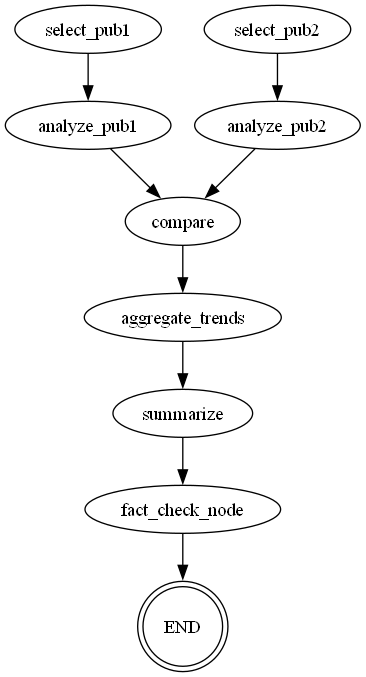

In [ ]:
# Visualize orchestration flow with Graphviz
from graphviz import Digraph
from IPython.display import Image, display

# Define nodes and edges for the flowchart
dot = Digraph(comment="Publication Comparison Flowchart", format='png')

# Nodes
dot.node('A', 'select_pub1')
dot.node('B', 'analyze_pub1')
dot.node('C', 'select_pub2')
dot.node('D', 'analyze_pub2')
dot.node('E', 'compare')
dot.node('F', 'aggregate_trends')
dot.node('G', 'summarize')
dot.node('H', 'fact_check_node')
dot.node('I', 'END', shape='doublecircle')

# Edges
dot.edge('A', 'B')
dot.edge('C', 'D')
dot.edge('B', 'E')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I')

# Render and display in Jupyter
dot.render('publication_flowchart', view=False)
display(Image(filename='publication_flowchart.png'))

**Explanation output**  The above flowchart is a clear example of **LangGraph orchestration**. It visually represents the sequence and dependencies of nodes (steps/agents) in your workflow, showing how data and control flow from one processing step to the next. Each node (e.g., `analyze_pub1`, `compare`, `summarize`) corresponds to a function or agent in your LangGraph, and the edges represent the transitions between these steps.

This kind of flowchart helps document, design, and communicate the orchestration logic of a LangGraph pipeline.